<a href="https://colab.research.google.com/github/a3mad/segmentation-ml/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement:** Using ccustomer segmentation for acquiring business insights.

Dataset source: [https://www.kaggle.com/datasets/ravalsmit/customer-segmentation-data](https://www.kaggle.com/datasets/ravalsmit/customer-segmentation-data)

**I imported the necessary libraries**

In [81]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.decomposition import PCA

**I setup Kaggle API in Colab**

N.T: when requested  Upload the Kaggle API key "kaggle.json"

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aemad83","key":"e72066e29c39f3e72bb25c3798bcc139"}'}

Make a directory for Kaggle and move the API key there

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

I downloaded the dataset from Kaggle

In [ ]:
!kaggle datasets download -d ravalsmit/customer-segmentation-data

Dataset URL: https://www.kaggle.com/datasets/ravalsmit/customer-segmentation-data
License(s): CC0-1.0
100% 1.76M/1.76M [00:00<00:00, 2.52MB/s]
100% 1.76M/1.76M [00:00<00:00, 2.24MB/s]


I extracted the downloaded dataset



In [ ]:
!unzip customer-segmentation-data.zip

Archive:  customer-segmentation-data.zip
  inflating: customer_segmentation_data.csv  


I load the dataset

In [82]:
file_path = '/content/customer_segmentation_data.csv'
df = pd.read_csv(file_path)

**Data exploration:**

I displayed the columns information and number of enteries

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53503 entries, 0 to 53502
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Customer ID                         53503 non-null  int64 
 1   Age                                 53503 non-null  int64 
 2   Gender                              53503 non-null  object
 3   Marital Status                      53503 non-null  object
 4   Education Level                     53503 non-null  object
 5   Geographic Information              53503 non-null  object
 6   Occupation                          53503 non-null  object
 7   Income Level                        53503 non-null  int64 
 8   Behavioral Data                     53503 non-null  object
 9   Purchase History                    53503 non-null  object
 10  Interactions with Customer Service  53503 non-null  object
 11  Insurance Products Owned            53503 non-null  ob

I searched for nullable values

In [ ]:
df.isnull().sum()

,0
Customer ID,0
Age,0
Gender,0
Marital Status,0
Education Level,0
Geographic Information,0
Occupation,0
Income Level,0
Behavioral Data,0
Purchase History,0


I displayed the first 5 rows

In [ ]:
df.head()

,Customer ID,Age,Gender,Marital Status,Education Level,Geographic Information,Occupation,Income Level,Behavioral Data,Purchase History,Interactions with Customer Service,Insurance Products Owned,Coverage Amount,Premium Amount,Policy Type,Customer Preferences,Preferred Communication Channel,Preferred Contact Time,Preferred Language,Segmentation Group
0,84966,23,Female,Married,Associate Degree,Mizoram,Entrepreneur,70541,policy5,04-10-2018,Phone,policy2,366603,2749,Group,Email,In-Person Meeting,Afternoon,English,Segment5
1,95568,26,Male,Widowed,Doctorate,Goa,Manager,54168,policy5,11-06-2018,Chat,policy1,780236,1966,Group,Mail,In-Person Meeting,Morning,French,Segment5
2,10544,29,Female,Single,Associate Degree,Rajasthan,Entrepreneur,73899,policy5,06-05-2021,Email,policy3,773926,4413,Group,Email,Mail,Evening,German,Segment3
3,77033,20,Male,Divorced,Bachelor's Degree,Sikkim,Entrepreneur,63381,policy5,09-02-2018,Chat,policy2,787815,4342,Family,Text,In-Person Meeting,Anytime,French,Segment3
4,88160,25,Female,Separated,Bachelor's Degree,West Bengal,Manager,38794,policy1,09-10-2018,Chat,policy4,366506,1276,Family,Email,Text,Weekends,English,Segment2


**Data Preprocessing:**

I select the relevant demographic features for segmentation

In [83]:
demographic_features = ["Age", "Gender", "Income Level", "Education Level", "Occupation", "Marital Status", "Insurance Products Owned"]
df_demo = df[demographic_features]

I used label encoder to encode the categorical features

In [84]:
label_encoders = {}
for column in ["Gender", "Education Level", "Occupation", "Marital Status", "Insurance Products Owned"]:
    le = LabelEncoder()
    df_demo.loc[:, column] = le.fit_transform(df_demo[column])
    label_encoders[column] = le

I used standarad scaler to normalize the numerical features

In [85]:
scaler = StandardScaler()
df_demo_scaled = scaler.fit_transform(df_demo.drop(columns=["Insurance Products Owned"]))

**Train and compare Clustering models:**

**KMeans Clustering**

Using Elbow Method to determine the optimal number of clusters for KMeans

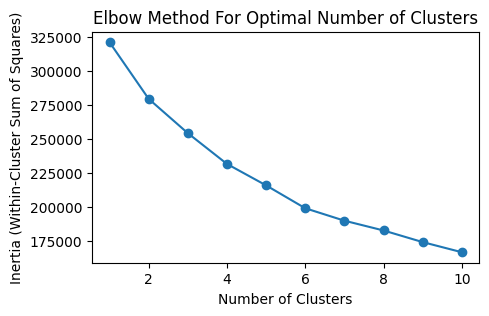

In [86]:
inertia_values = []
range_n_clusters = range(1, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_demo_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(5, 3))
plt.plot(range_n_clusters, inertia_values, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.show()

Determine Optimal Number of Clusters using Silhouette Scores

In [87]:
silhouette_scores = []
range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_demo_scaled)
    silhouette_avg = silhouette_score(df_demo_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_n_clusters}")

Optimal number of clusters based on silhouette score: 10


display the Silhouette Scores graph to visualize the scores

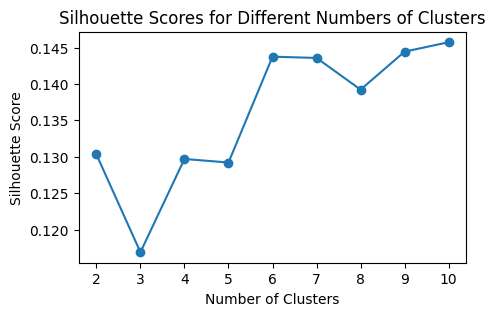

In [88]:
plt.figure(figsize=(5, 3))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

The elbow wasn't very decisve, so I used the silhouette score and graph.Although highest score for 10 clusters, but the graph displays small difference between 6 and 10 clusters so I'll go with 6 clusters so the clusters be easier to interpret

In [ ]:
results = {}
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(df_demo_scaled)
if len(set(kmeans_labels)) > 1:
    kmeans_silhouette = silhouette_score(df_demo_scaled, kmeans_labels)
    kmeans_db_score = davies_bouldin_score(df_demo_scaled, kmeans_labels)
    results['KMeans'] = {
        'Silhouette Score': kmeans_silhouette,
        'Davies-Bouldin Score': kmeans_db_score
    }
    print("\nKMeans Results:")
    print(results['KMeans'])
else:
    print("\nKMeans could not form sufficient clusters")


KMeans Results:
{'Silhouette Score': 0.14374313362562224, 'Davies-Bouldin Score': 1.9576403542611909}



**Agglomerative Clustering**

N.T: I limted the sample size to avoid crashing due to high memory usage

In [ ]:
sample_size = 30000
if len(df_demo_scaled) > sample_size:
    df_demo_sample = df_demo_scaled[np.random.choice(df_demo_scaled.shape[0], sample_size, replace=False), :]
else:
    df_demo_sample = df_demo_scaled

agglo = AgglomerativeClustering(n_clusters=6)
agglo_labels = agglo.fit_predict(df_demo_sample)
if len(set(agglo_labels)) > 1:
    agglo_silhouette = silhouette_score(df_demo_sample, agglo_labels)
    agglo_db_score = davies_bouldin_score(df_demo_sample, agglo_labels)
    results['AgglomerativeClustering'] = {
        'Silhouette Score': agglo_silhouette,
        'Davies-Bouldin Score': agglo_db_score
    }
    print("\nAgglomerative Clustering Results:")
    print(results['AgglomerativeClustering'])
else:
    print("\nAgglomerative Clustering could not form sufficient clusters")


Agglomerative Clustering Results:
{'Silhouette Score': 0.09923283429176519, 'Davies-Bouldin Score': 2.169661212445458}


DBSCAN Clustering





In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=6)
dbscan_labels = dbscan.fit_predict(df_demo_scaled)
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(df_demo_scaled, dbscan_labels)
    dbscan_db_score = davies_bouldin_score(df_demo_scaled, dbscan_labels)
    results['DBSCAN'] = {
        'Silhouette Score': dbscan_silhouette,
        'Davies-Bouldin Score': dbscan_db_score
    }
    print("\nDBSCAN Results:")
    print(results['DBSCAN'])
else:
    print("\nDBSCAN could not form sufficient clusters")


DBSCAN Results:
{'Silhouette Score': 0.003471990088421322, 'Davies-Bouldin Score': 4.471825259072105}


I compare the scores to determine the best model

In [ ]:
best_model = None
best_silhouette = -1
best_db_score = float('inf')

for model_name, metrics in results.items():
    if metrics['Silhouette Score'] > best_silhouette or (metrics['Silhouette Score'] == best_silhouette and metrics['Davies-Bouldin Score'] < best_db_score):
        best_model = model_name
        best_silhouette = metrics['Silhouette Score']
        best_db_score = metrics['Davies-Bouldin Score']

print(f"\nBest Model: {best_model}")
print({
    'Silhouette Score': best_silhouette,
    'Davies-Bouldin Score': best_db_score
})


Best Model: KMeans
{'Silhouette Score': 0.14374313362562224, 'Davies-Bouldin Score': 1.9576403542611909}


K means proven to be the best clustering model for this case with the highest silhouette score and lowest Davies-Bouldin Score

**Feature Analysis for KMeans Clusters:**




**Descriptive statistics per cluster**



In [ ]:
segmentation_results = df_demo.copy()
segmentation_results['Cluster'] = kmeans_labels
for cluster in segmentation_results['Cluster'].unique():
    cluster_data = segmentation_results[segmentation_results['Cluster'] == cluster]
    print(f"\nCluster {cluster} Summary:")
    print(cluster_data.describe(include='all'))


Cluster 4 Summary:
                Age  Gender  Income Level  Education Level  Occupation  \
count   8761.000000  8761.0   8761.000000           8761.0      8761.0   
unique          NaN     1.0           NaN              5.0         9.0   
top             NaN     0.0           NaN              2.0         7.0   
freq            NaN  8761.0           NaN           2141.0      1377.0   
mean      34.480196     NaN  51481.306586              NaN         NaN   
std        8.994118     NaN  17063.582684              NaN         NaN   
min       18.000000     NaN  20001.000000              NaN         NaN   
25%       26.000000     NaN  37179.000000              NaN         NaN   
50%       35.000000     NaN  51836.000000              NaN         NaN   
75%       41.000000     NaN  65702.000000              NaN         NaN   
max       56.000000     NaN  89582.000000              NaN         NaN   

        Marital Status  Insurance Products Owned  Cluster  
count           8761.0         

**Defining characteristics of each cluster for easier targeting**

From the statistical overview I created labels for clusters to easily differentiate them for target marketing:
* Age:ranges (young: <35, middle-aged: 35–55, senior: >55)
* Income: low: bottom 25%, medium: 25–75%, high: top 25%)
* Occubation & Gender: I identified the most frequent value using mode()

Then I combined them together to describe the clusters

In [ ]:
cluster_labels = {}

for cluster in segmentation_results['Cluster'].unique():
    cluster_data = segmentation_results[segmentation_results['Cluster'] == cluster]

    mean_age = cluster_data['Age'].mean()
    mean_income = cluster_data['Income Level'].mean()
    common_occupation = cluster_data['Occupation'].mode()[0]
    dominant_gender = cluster_data['Gender'].mode()[0]

    if mean_age < 35:
        age_group = "Young"
    elif mean_age <= 55:
        age_group = "Middle-Aged"
    else:
        age_group = "Senior"

    if mean_income < 50000:
        income_level = "Low-Income"
    elif mean_income <= 100000:
        income_level = "Medium-Income"
    else:
        income_level = "High-Income"

    occupation_label = label_encoders['Occupation'].inverse_transform([common_occupation])[0]
    gender_label = label_encoders['Gender'].inverse_transform([dominant_gender])[0]
    cluster_labels[cluster] = f"{age_group} {income_level} {occupation_label}, Mostly {gender_label}"

segmentation_results['Cluster Label'] = segmentation_results['Cluster'].map(cluster_labels)
print(segmentation_results[['Cluster', 'Cluster Label']].drop_duplicates())


    Cluster                                      Cluster Label
0         4     Young Medium-Income Salesperson, Mostly Female
1         2  Middle-Aged Medium-Income Entrepreneur, Mostly...
3         5  Middle-Aged Medium-Income Salesperson, Mostly ...
5         0  Middle-Aged High-Income Salesperson, Mostly Fe...
13        1    Senior Medium-Income Salesperson, Mostly Female
19        3   Middle-Aged High-Income Salesperson, Mostly Male


I used the generated labels to display the segments in a reduced dimension 2d figure

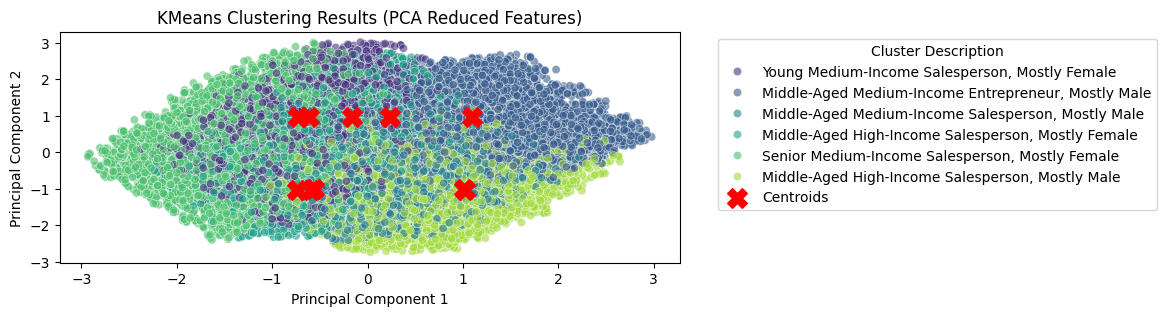

In [93]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_demo_scaled)

plt.figure(figsize=(8, 3))
sns.scatterplot(
    x=df_pca[:, 0],
    y=df_pca[:, 1],
    hue=segmentation_results['Cluster Label'],
    palette='viridis',
    alpha=0.6,
    edgecolor='w'
)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('KMeans Clustering Results (PCA Reduced Features)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

I also used an interactive 3d figure to display the segments better

In [ ]:
import plotly.express as px

pca_3d = PCA(n_components=3)
df_pca_3d = pca_3d.fit_transform(df_demo_scaled)
df_pca_3d = pd.DataFrame(df_pca_3d, columns=["PC1", "PC2", "PC3"])
df_pca_3d['Cluster'] = kmeans_labels
df_pca_3d['Cluster Label'] = df_pca_3d['Cluster'].map(cluster_labels)
fig = px.scatter_3d(
    df_pca_3d,
    x='PC1', y='PC2', z='PC3',
    color='Cluster Label',
    title='3D PCA Clustering Results',
    opacity=0.7,
    labels={'color': 'Cluster Label'}
)
fig.show()

**Investigating Which clusters have the highest potential for product upselling**

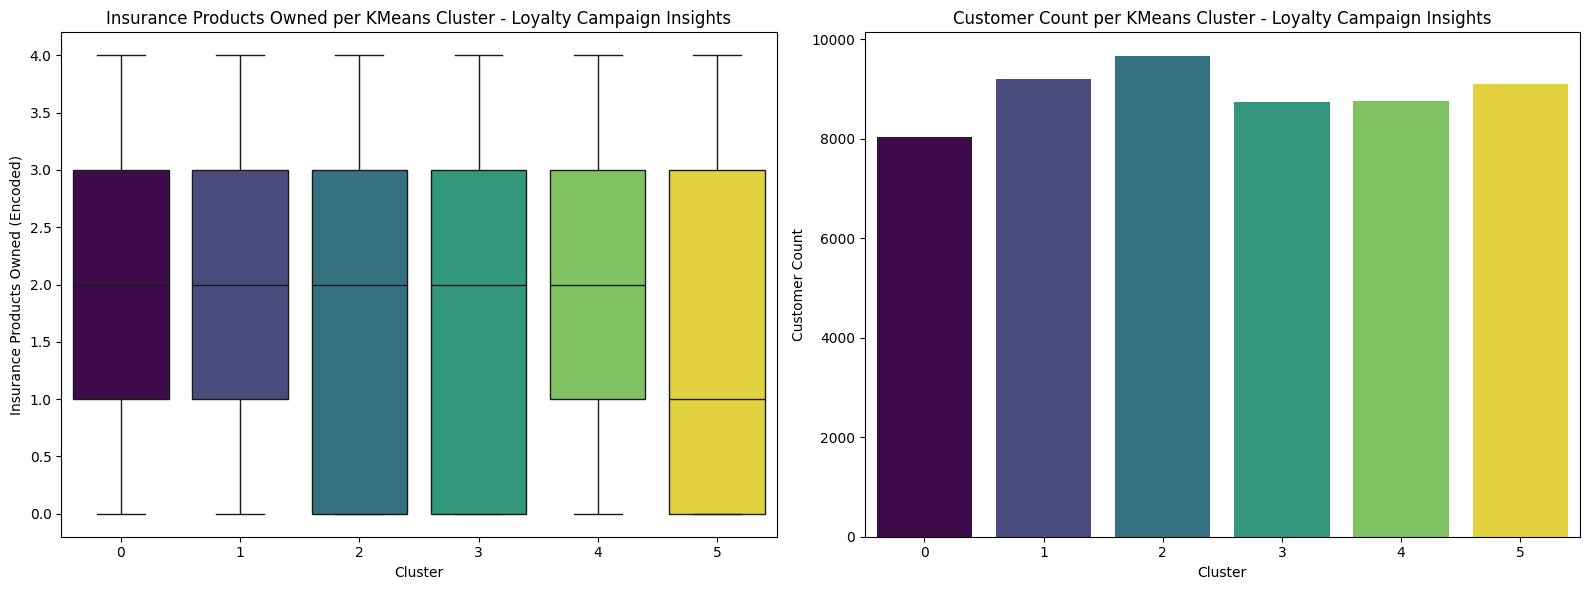

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

segmentation_results['Insurance Products Owned'] = pd.to_numeric(segmentation_results['Insurance Products Owned'], errors='coerce')
sns.boxplot(ax=axes[0], x='Cluster', y='Insurance Products Owned', data=segmentation_results, hue='Cluster', palette='viridis', legend=False)
axes[0].set_title('Insurance Products Owned per KMeans Cluster - Loyalty Campaign Insights')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Insurance Products Owned (Encoded)')

sns.countplot(ax=axes[1], x='Cluster', data=segmentation_results, hue='Cluster', palette='viridis', legend=False)
axes[1].set_title('Customer Count per KMeans Cluster - Loyalty Campaign Insights')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Customer Count')
axes[1].set_title('Customer Count per KMeans Cluster - Loyalty Campaign Insights')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Customer Count')

plt.tight_layout()
plt.show()

**Clusters with highest potential for upselling**

In [ ]:
loyalty_clusters = segmentation_results.groupby('Cluster')['Insurance Products Owned'].mean().sort_values(ascending=False).index[:2]
for cluster in loyalty_clusters:
    cluster_name = segmentation_results.loc[segmentation_results['Cluster'] == cluster, 'Cluster Label'].iloc[0]
    print(f"Cluster '{cluster_name}' shows high engagement with existing products, indicating potential for loyalty and retention campaigns.")

upsell_clusters = segmentation_results.groupby('Cluster')['Income Level'].mean().sort_values(ascending=False).index[:2]
for cluster in upsell_clusters:
    cluster_name = segmentation_results.loc[segmentation_results['Cluster'] == cluster, 'Cluster Label'].iloc[0]
    print(f"Cluster '{cluster_name}' has higher income levels and a lower number of insurance products owned, indicating potential for upselling additional products.")


Cluster 'Middle-Aged High-Income Salesperson, Mostly Female' shows high engagement with existing products, indicating potential for loyalty and retention campaigns.
Cluster 'Senior Medium-Income Salesperson, Mostly Female' shows high engagement with existing products, indicating potential for loyalty and retention campaigns.
Cluster 'Middle-Aged High-Income Salesperson, Mostly Male' has higher income levels and a lower number of insurance products owned, indicating potential for upselling additional products.
Cluster 'Middle-Aged High-Income Salesperson, Mostly Female' has higher income levels and a lower number of insurance products owned, indicating potential for upselling additional products.


**Investigating customer behaviors that are most indicative of high-value product interest?**



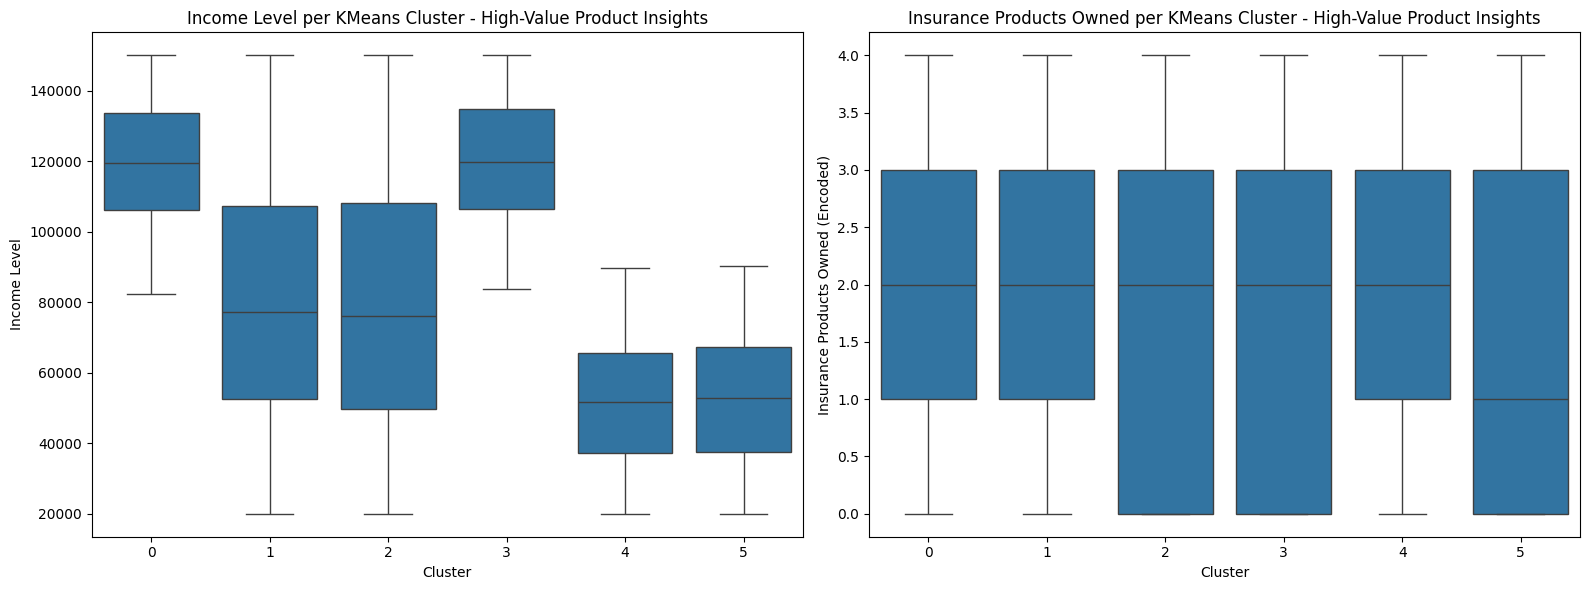

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(ax=axes[0], x='Cluster', y='Income Level', data=segmentation_results)
axes[0].set_title('Income Level per KMeans Cluster - High-Value Product Insights')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Income Level')

sns.boxplot(ax=axes[1], x='Cluster', y='Insurance Products Owned', data=segmentation_results)
axes[1].set_title('Insurance Products Owned per KMeans Cluster - High-Value Product Insights')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Insurance Products Owned (Encoded)')

plt.tight_layout()
plt.show()


**clusters most likely to purchase high-value products**

In [ ]:
high_value_clusters = segmentation_results.groupby('Cluster')['Income Level'].mean().sort_values(ascending=False).index[:2]
for cluster in high_value_clusters:
    cluster_name = segmentation_results.loc[segmentation_results['Cluster'] == cluster, 'Cluster Label'].iloc[0]
    print(f"Cluster '{cluster_name}' seems to have higher income levels and could be targeted for high-value insurance products.")


Cluster 'Middle-Aged High-Income Salesperson, Mostly Male' seems to have higher income levels and could be targeted for high-value insurance products.
Cluster 'Middle-Aged High-Income Salesperson, Mostly Female' seems to have higher income levels and could be targeted for high-value insurance products.


**Final disccusion:**

After comparing between the clustering methods to choose the best one, I was able to extract some businesss insights from the clustering analysis, more insights could be extracted based on the business needs.